In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Load the data

In [41]:
from sqlalchemy import create_engine


driver = 'mysql+pymysql:'
user = 'adria'
password = '00000'
ip = '35.187.114.125'
database = 'vimet'

connection_string = f'{driver}//{user}:{password}@{ip}/{database}'
engine = create_engine(connection_string)

In [42]:
items = pd.read_sql('items', con = engine)

Before looking at similarities, we will drop the orders related to 'El Gran Recapte' as they are considered outliers

In [43]:
items = items[items['Vendor'] != 'Gran Recapte']

We will also drop the orders with tag 'Cesta' as they refer to a new method of selling and are also considered outliers

In [44]:
items = items[items['tags'] != 'Cesta']

### Create a data frame that contains the total quantity of each product purchased by each order

In [45]:
rec = items.groupby(['Name', 'tags']).sum()[['Lineitem quantity']]

### Create a product by order matrix

In [46]:
df_pivot = rec.pivot_table(index='tags', columns='Name', values='Lineitem quantity').fillna(0)
df_pivot.head()

Name,#1001,#1002,#1003,#1004,#1005,#1006,#1007,#1008,#1009,#1010,...,#1239,#1240,#1241,#1242,#1243,#1244,#1245,#1246,#1247,#1248
tags,,,,,,,,,,,,,,,,,,,,,
Aceite,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Acelgas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Agua,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aguacate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Ajo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


### Create an order similarity matrix

In [56]:
from scipy.spatial.distance import pdist, squareform
similarity_matrix = squareform(pdist(df_pivot.T, 'cosine'))
similarity_matrix

array([[0.        , 1.        , 1.        , ..., 0.84382624, 0.79148559,
        1.        ],
       [1.        , 0.        , 1.        , ..., 0.84382624, 0.79148559,
        1.        ],
       [1.        , 1.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [0.84382624, 0.84382624, 1.        , ..., 0.        , 0.60922623,
        0.6095656 ],
       [0.79148559, 0.79148559, 1.        , ..., 0.60922623, 0.        ,
        0.65247598],
       [1.        , 1.        , 1.        , ..., 0.6095656 , 0.65247598,
        0.        ]])

### Top 5 most similar orders for a specific order.

In [57]:
similarity_df = pd.DataFrame(similarity_matrix, index=df_pivot.columns, columns=df_pivot.columns)

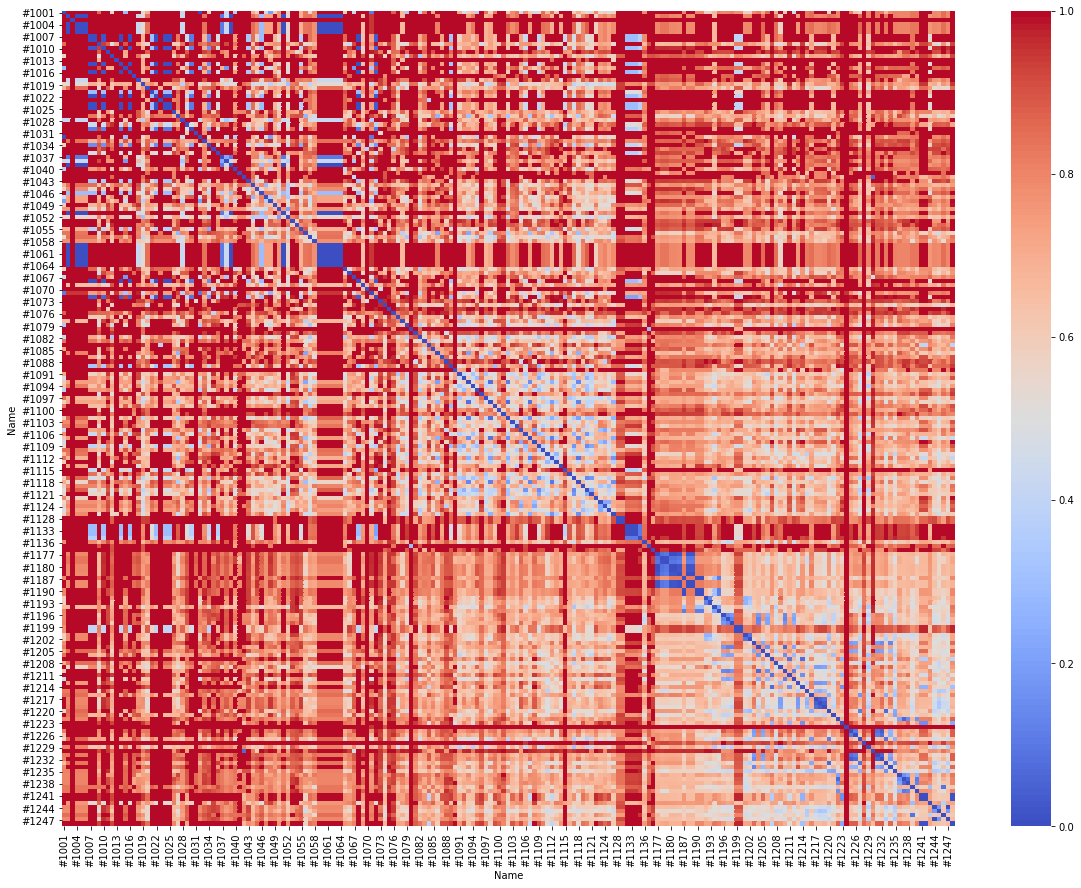

In [58]:
plt.figure(figsize=(20,15))
cmap = sns.color_palette("coolwarm", 128)
sns.heatmap(similarity_df, cmap=cmap)

plt.show()

We see that orders #1061, #1064, #1004 are very similiar, let's take a look at the items they have to check whether the similarity is calculated correclty

In [50]:
items[items['Name'] == '#1061']

,index,Name,Lineitem quantity,Lineitem name,Lineitem price,Lineitem fulfillment status,Cancelled at,Refunded Amount,Vendor,Lineitem discount,tags
2685,2685,#1061,1,Huevos - 1/2 docena,1.5,pending,2017-09-15 21:34:12 +0200,0.0,Aviram Mónica,0,Huevos


In [51]:
items[items['Name'] == '#1064']

,index,Name,Lineitem quantity,Lineitem name,Lineitem price,Lineitem fulfillment status,Cancelled at,Refunded Amount,Vendor,Lineitem discount,tags
2682,2682,#1064,1,Huevos - 1/2 docena,1.5,pending,2017-09-15 21:33:34 +0200,0.0,Aviram Mónica,0,Huevos


In [59]:
items[items['Name'] == '#1004']

,index,Name,Lineitem quantity,Lineitem name,Lineitem price,Lineitem fulfillment status,Cancelled at,Refunded Amount,Vendor,Lineitem discount,tags
3116,3116,#1004,1,Huevos - 6 unidades,1.5,pending,2017-06-27 17:18:38 +0200,1.5,Aviram Mónica,0,Huevos


In [60]:
items[items['Name'] == '#1007']

,index,Name,Lineitem quantity,Lineitem name,Lineitem price,Lineitem fulfillment status,Cancelled at,Refunded Amount,Vendor,Lineitem discount,tags
3113,3113,#1007,1,Culata al corte - 2 unidades,7.5,pending,not cancelled,0.0,Carnicería Vidal,0,Ternera


In [61]:
items[items['Name'] == '#1025']

,index,Name,Lineitem quantity,Lineitem name,Lineitem price,Lineitem fulfillment status,Cancelled at,Refunded Amount,Vendor,Lineitem discount,tags
3005,3005,#1025,1,Mitjana deshuesada - 2 unidades,8.0,pending,not cancelled,0.0,Carnicería Vidal,0,Ternera
3006,3006,#1025,2,Hamburguesas de queso - 2 unidades,3.0,pending,not cancelled,0.0,Carnicería Vidal,0,Ternera


We define a new DataFrame with all the distances below 0.1. This will identify the most similar orders.

In [123]:
level_1 = similarity_df[similarity_df  < 0.1]

In [124]:
level_1.head()

Name,#1001,#1002,#1003,#1004,#1005,#1006,#1007,#1008,#1009,#1010,...,#1239,#1240,#1241,#1242,#1243,#1244,#1245,#1246,#1247,#1248
Name,,,,,,,,,,,,,,,,,,,,,
#1001,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
#1002,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
#1003,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
#1004,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
#1005,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's check two similar (not equal) orders for a given order

In [125]:
list(level_1[level_1['#1248'] >= 0]['#1248'].index)

['#1241', '#1242', '#1248']

In [82]:
items[items['Name']=='#1241']

,index,Name,Lineitem quantity,Lineitem name,Lineitem price,Lineitem fulfillment status,Cancelled at,Refunded Amount,Vendor,Lineitem discount,tags
121,121,#1241,4,Plátano Canarias - 3/4 unidades,1.95,fulfilled,not cancelled,0.0,Fruites i Verdures Rovira,0,Plátano
122,122,#1241,2,Fresón Maresme - 1 caja (500 grs.),3.50,fulfilled,not cancelled,0.0,Fruites i Verdures Rovira,0,Fresón
123,123,#1241,1,Tomate Cherry - 200 grs,1.30,fulfilled,not cancelled,0.0,Fruites i Verdures Rovira,0,Tomate
124,124,#1241,1,Nueces California sin cáscara - 200 grs,3.44,fulfilled,not cancelled,0.0,Llegums Porta Novau,0,Nuez
125,125,#1241,3,Mandarina Orri - 500 grs.,2.00,fulfilled,not cancelled,0.0,Fruites i Verdures Rovira,0,Mandarina
126,126,#1241,2,Manzana Pink Lady - 4 unidades,3.50,fulfilled,not cancelled,0.0,Fruites i Verdures Rovira,0,Manzana
127,127,#1241,1,Almendra Cruda - 125 grs.,2.00,fulfilled,not cancelled,0.0,Llegums Porta Novau,0,Almendra
128,128,#1241,1,Manchego oveja Lenceras - a triángulos (200 grs.),4.40,fulfilled,not cancelled,0.0,Xarcuteria Alonso Andrés,0,Queso


In [83]:
items[items['Name']=='#1248']

,index,Name,Lineitem quantity,Lineitem name,Lineitem price,Lineitem fulfillment status,Cancelled at,Refunded Amount,Vendor,Lineitem discount,tags
0,0,#1248,4,Plátano Canarias - 3/4 unidades,1.95,fulfilled,not cancelled,0.0,Fruites i Verdures Rovira,0,Plátano
1,1,#1248,2,Fresón Maresme - 1 caja (500 grs.),3.50,fulfilled,not cancelled,0.0,Fruites i Verdures Rovira,0,Fresón
2,2,#1248,1,Tomate Cherry - 200 grs,1.30,fulfilled,not cancelled,0.0,Fruites i Verdures Rovira,0,Tomate
3,3,#1248,1,Nueces California sin cáscara - 200 grs,3.44,fulfilled,not cancelled,0.0,Llegums Porta Novau,0,Nuez
4,4,#1248,3,Mandarina Orri - 500 grs.,2.00,fulfilled,not cancelled,0.0,Fruites i Verdures Rovira,0,Mandarina
5,5,#1248,2,Manzana Pink Lady - 4 unidades,3.50,fulfilled,not cancelled,0.0,Fruites i Verdures Rovira,0,Manzana
6,6,#1248,1,Almendra Cruda - 125 grs.,2.00,fulfilled,not cancelled,0.0,Llegums Porta Novau,0,Almendra


We can see that the two orders differ only in 1 item (the #1241 has cheese and the other doesn't). Thus we could recommend cheese to be included in order #1248.

In [109]:
# We define a function to fully identify similar orders, given an items dataframe a level of similarity and 
# the name of the order

# Required fields in the DF: 'Vendor', 'tags', 'Name' and 'Lineitem quantity'
def item_recomender(df, level, name):
    #Import the needed libraries
    from scipy.spatial.distance import pdist, squareform
    #Drop outliers
    df = df[df['Vendor'] != 'Gran Recapte']
    df = df[df['tags'] != 'Cesta']
    #Build similarity matrix
    rec = df.groupby(['Name', 'tags']).sum()[['Lineitem quantity']]
    df_pivot = rec.pivot_table(index='tags', columns='Name', values='Lineitem quantity').fillna(0)
    similarity_matrix = squareform(pdist(df_pivot.T, 'cosine'))
    similarity_df = pd.DataFrame(similarity_matrix, index=df_pivot.columns, columns=df_pivot.columns)
    #Filter by level of similarity
    result = similarity_df[similarity_df >= ((level-1)/10)]    
    result = result[result < level/10]
    #Return the list or orders without the order provided
    return (list(result[result[name] >= 0][name].index).remove(name))

In [113]:
item_recomender(items, 1, '#1248')

['#1241', '#1242', '#1248']